# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.056150,True,5.106488
1,0.860579,True,5.467471
2,1.043068,True,6.152948
3,-1.867052,False,-1.350485
4,-0.901729,False,-0.446397
...,...,...,...
995,-1.373709,False,-1.904501
996,-0.971277,False,-0.439460
997,0.371798,True,4.599150
998,-0.084764,True,3.801222


<AxesSubplot:xlabel='v0'>

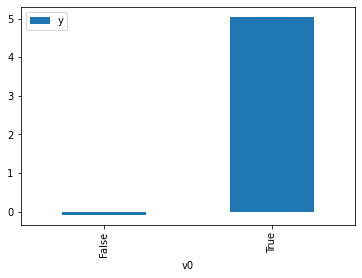

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

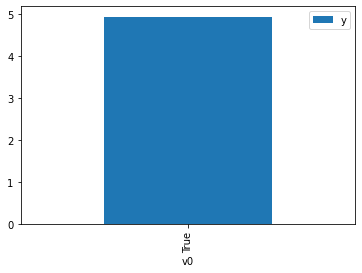

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.043842,False,-0.059877,0.511101,1.956559
1,-0.695678,False,-1.380021,0.819656,1.220024
2,-0.881935,False,-1.994652,0.873686,1.144577
3,0.416148,False,-0.421346,0.270386,3.698414
4,-0.064290,False,1.132985,0.522613,1.913461
...,...,...,...,...,...
995,-1.768236,False,-0.170388,0.980776,1.019601
996,-1.079218,False,-0.506579,0.915191,1.092668
997,0.719911,False,0.052587,0.157425,6.352245
998,0.520055,False,-0.174761,0.226720,4.410735


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.017847,True,5.511637,0.096183,10.396806
1,-0.564461,True,4.869968,0.228257,4.381033
2,-1.092108,True,4.096475,0.082580,12.109433
3,0.736229,True,4.670668,0.847394,1.180088
4,-0.904448,True,2.982361,0.120818,8.276898
...,...,...,...,...,...
995,-1.092108,True,4.096475,0.082580,12.109433
996,-0.387463,True,3.537784,0.305949,3.268521
997,0.284311,True,6.295199,0.667174,1.498860
998,-0.453987,True,5.747272,0.275058,3.635601


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              5722.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):                        0.00
Time:                        09:42:48   Log-Likelihood:                         -1435.5
No. Observations:                1000   AIC:                                      2875.
Df Residuals:                     998   BIC:                                      2885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5402      0.033     16.414      0.000       0.476       0.605
x2             5.0260      0.052     97.004      0.000       4.924       5.128
==============================================================================
Omnibus:                        2.393   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.428
Skew:                          -0.118   Prob(JB):                        0.297
Kurtosis:                       2.952   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""